In [8]:
import numpy as np 
import pickle, json
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
import pandas as pd

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
# uses the fitted coefficient of logistic regression classifier 
# to determine the words most indicative of each bias
def importantWords(class_num, classifier, vocab):
    all_coefs = []
    for i in range(len(classifier.coef_[class_num])):
        coef_tuple = (classifier.coef_[class_num][i], i)
        all_coefs.append(coef_tuple)
    all_coefs.sort(key=lambda tup: tup[0])
    most_neg = all_coefs[0:40]
    most_pos = all_coefs[-40:]
    most_pos = most_pos[::-1]
    
    neg_indices = []
    pos_indices = []
    for i in range(len(most_neg)):
        neg_indices.append(most_neg[i][1])
        pos_indices.append(most_pos[i][1])
    
    print('Most Negative')
    print(np.array(vocab)[neg_indices])
    print('Most Positive')
    print(np.array(vocab)[pos_indices])

In [17]:
# given a list of classifiers generate data needed for the ROC curve
def makeROC(predicted_probas, y, namesList, graphTitle):
    y_binarized = label_binarize(y, classes=[0, 1, 2])
    
    n_classes=3
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for name, predicted_proba in zip(namesList, predicted_probas):
        fpr[name] = [None] * 3
        tpr[name] = [None] * 3
        roc_auc[name] = [None] * 3
        for i in range(n_classes):
            fpr[name][i], tpr[name][i], _ = roc_curve(y_binarized[:, i], predicted_proba[:, i])
            roc_auc[name][i] = auc(fpr[name][i], tpr[name][i])
        
    plt.figure(figsize=(8, 8))
    lw = 2
    for name in namesList:
        plt.plot(fpr[name][0], tpr[name][0],
                 lw=lw, label='{0} (area = {1})'.format(name, roc_auc[name][0]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Positive = Democrat)')
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure(figsize=(8, 8))
    lw = 2
    for name in namesList:
        plt.plot(fpr[name][1], tpr[name][1],
                 lw=lw, label='{0} (area = {1})'.format(name, roc_auc[name][1]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Positive = Republican)')
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure(figsize=(8, 8))
    lw = 2
    for name in namesList:
        plt.plot(fpr[name][2], tpr[name][2],
                 lw=lw, label='{0} (area = {1})'.format(name, roc_auc[name][2]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Positive = Centrist)')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
# specifically trains a logistic regression l2-norm classifier using rfecv
def makell2(X, y):
    X = TfidfTransformer().fit_transform(X,y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
    
    log_l2 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
    rfecv = RFECV(estimator=log_l2, step=200, cv=3, n_jobs=-1, min_features_to_select=100).fit(X_train, y_train)
    print('Logistic accuracy: {0}'.format(rfecv.estimator_.score(X_test[:,rfecv.support_], y_test)))
    print('Logistic num features: {0}'.format(rfecv.n_features_))
    return rfecv, rfecv.support_

In [19]:
# trains various models using rfecv and outputting performance metrics
def trainModelsRFECV(X, y):
    X = TfidfTransformer().fit_transform(X,y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
    
    #rf = RandomForestClassifier(bootstrap=True, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300)
    rf = RandomForestClassifier()
    #{'bootstrap': True, 'max_depth': 100, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 1000}
    rfecv = RFECV(estimator=rf, step=200, cv=3, n_jobs=-1, min_features_to_select=100).fit(X_train, y_train)
    print('RF accuracy: {0}'.format(rfecv.estimator_.score(X_test[:,rfecv.support_], y_test)))
    print('RF num features: {0}'.format(rfecv.n_features_))
    pred = rfecv.estimator_.predict(X_test[:, rfecv.support_])
    print('RF precision dem: {0}'.format(metrics.precision_score(y_test, pred, pos_label=0, average='weighted')))
    print('RF precision repub: {0}'.format(metrics.precision_score(y_test, pred, pos_label=1, average='weighted')))
    print('RF precision cen: {0}'.format(metrics.precision_score(y_test, pred, pos_label=2, average='weighted')))
    print('RF recall dem: {0}'.format(metrics.recall_score(y_test, pred, pos_label=0, average='weighted')))
    print('RF recall repub: {0}'.format(metrics.recall_score(y_test, pred, pos_label=1, average='weighted')))
    print('RF recall cen: {0}'.format(metrics.recall_score(y_test, pred, pos_label=2, average='weighted')))
    print('RF f1 dem: {0}'.format(metrics.f1_score(y_test, pred, pos_label=0, average='weighted')))
    print('RF f1 repub: {0}'.format(metrics.f1_score(y_test, pred, pos_label=1, average='weighted')))
    print('RF f1 cen: {0}'.format(metrics.f1_score(y_test, pred, pos_label=2, average='weighted')))
    rf_pv = rfecv.estimator_.predict_proba(X_test[:, rfecv.support_])
    
    mnb = MultinomialNB()
    rfecv = RFECV(estimator=mnb, step=200, cv=3, n_jobs=-1, min_features_to_select=100).fit(X_train, y_train)
    print('MNB accuracy: {0}'.format(rfecv.estimator_.score(X_test[:,rfecv.support_], y_test)))
    print('MNB num features: {0}'.format(rfecv.n_features_))
    pred = rfecv.estimator_.predict(X_test[:, rfecv.support_])
    print('MNB precision dem: {0}'.format(metrics.precision_score(y_test, pred, pos_label=0, average='weighted')))
    print('MNB precision repub: {0}'.format(metrics.precision_score(y_test, pred, pos_label=1, average='weighted')))
    print('MNB precision cen: {0}'.format(metrics.precision_score(y_test, pred, pos_label=2, average='weighted')))
    print('MNB recall dem: {0}'.format(metrics.recall_score(y_test, pred, pos_label=0, average='weighted')))
    print('MNB recall repub: {0}'.format(metrics.recall_score(y_test, pred, pos_label=1, average='weighted')))
    print('MNB recall cen: {0}'.format(metrics.recall_score(y_test, pred, pos_label=2, average='weighted')))
    print('MNB f1 dem: {0}'.format(metrics.f1_score(y_test, pred, pos_label=0, average='weighted')))
    print('MNB f1 repub: {0}'.format(metrics.f1_score(y_test, pred, pos_label=1, average='weighted')))
    print('MNB f1 cen: {0}'.format(metrics.f1_score(y_test, pred, pos_label=2, average='weighted')))
    mnb_pv = rfecv.estimator_.predict_proba(X_test[:, rfecv.support_])
    
    bnb = BernoulliNB()
    rfecv = RFECV(estimator=bnb, step=200, cv=3, n_jobs=-1, min_features_to_select=100).fit(X_train, y_train)
    print('BNB accuracy: {0}'.format(rfecv.estimator_.score(X_test[:,rfecv.support_], y_test)))
    print('BNB num features: {0}'.format(rfecv.n_features_))
    pred = rfecv.estimator_.predict(X_test[:, rfecv.support_])
    
    print('BNB precision dem: {0}'.format(metrics.precision_score(y_test, pred, pos_label=0, average='weighted')))
    print('BNB precision repub: {0}'.format(metrics.precision_score(y_test, pred, pos_label=1, average='weighted')))
    print('BNB precision cen: {0}'.format(metrics.precision_score(y_test, pred, pos_label=2, average='weighted')))
    print('BNB recall dem: {0}'.format(metrics.recall_score(y_test, pred, pos_label=0, average='weighted')))
    print('BNB recall repub: {0}'.format(metrics.recall_score(y_test, pred, pos_label=1, average='weighted')))
    print('BNB recall cen: {0}'.format(metrics.recall_score(y_test, pred, pos_label=2, average='weighted')))
    print('BNB f1 dem: {0}'.format(metrics.f1_score(y_test, pred, pos_label=0, average='weighted')))
    print('BNB f1 repub: {0}'.format(metrics.f1_score(y_test, pred, pos_label=1, average='weighted')))
    print('BNB f1 cen: {0}'.format(metrics.f1_score(y_test, pred, pos_label=2, average='weighted')))
    bnb_pv = rfecv.estimator_.predict_proba(X_test[:, rfecv.support_])
    
    cnb = ComplementNB()
    rfecv = RFECV(estimator=cnb, step=200, cv=3, n_jobs=-1, min_features_to_select=100).fit(X_train, y_train)
    print('CNB accuracy: {0}'.format(rfecv.estimator_.score(X_test[:,rfecv.support_], y_test)))
    print('CNB num features: {0}'.format(rfecv.n_features_))
    pred = rfecv.estimator_.predict(X_test[:, rfecv.support_])
    print('CNB precision dem: {0}'.format(metrics.precision_score(y_test, pred, pos_label=0, average='weighted')))
    print('CNB precision repub: {0}'.format(metrics.precision_score(y_test, pred, pos_label=1, average='weighted')))
    print('CNB precision cen: {0}'.format(metrics.precision_score(y_test, pred, pos_label=2, average='weighted')))
    print('CNB recall dem: {0}'.format(metrics.recall_score(y_test, pred, pos_label=0, average='weighted')))
    print('CNB recall repub: {0}'.format(metrics.recall_score(y_test, pred, pos_label=1, average='weighted')))
    print('CNB recall cen: {0}'.format(metrics.recall_score(y_test, pred, pos_label=2, average='weighted')))
    print('CNB f1 dem: {0}'.format(metrics.f1_score(y_test, pred, pos_label=0, average='weighted')))
    print('CNB f1 repub: {0}'.format(metrics.f1_score(y_test, pred, pos_label=1, average='weighted')))
    print('CNB f1 cen: {0}'.format(metrics.f1_score(y_test, pred, pos_label=2, average='weighted')))
    cnb_pv = rfecv.estimator_.predict_proba(X_test[:, rfecv.support_])
    
    log_l1 = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=1000)
    rfecv = RFECV(estimator=log_l1, step=200, cv=3, n_jobs=-1, min_features_to_select=100).fit(X_train, y_train)
    print('Logistic accuracy: {0}'.format(rfecv.estimator_.score(X_test[:,rfecv.support_], y_test)))
    print('Logistic num features: {0}'.format(rfecv.n_features_))
    pred = rfecv.estimator_.predict(X_test[:, rfecv.support_])
    print('LL1 precision dem: {0}'.format(metrics.precision_score(y_test, pred, pos_label=0, average='weighted')))
    print('LL1 precision repub: {0}'.format(metrics.precision_score(y_test, pred, pos_label=1, average='weighted')))
    print('LL1 precision cen: {0}'.format(metrics.precision_score(y_test, pred, pos_label=2, average='weighted')))
    print('LL1 recall dem: {0}'.format(metrics.recall_score(y_test, pred, pos_label=0, average='weighted')))
    print('LL1 recall repub: {0}'.format(metrics.recall_score(y_test, pred, pos_label=1, average='weighted')))
    print('LL1 recall cen: {0}'.format(metrics.recall_score(y_test, pred, pos_label=2, average='weighted')))
    print('LL1 f1 dem: {0}'.format(metrics.f1_score(y_test, pred, pos_label=0, average='weighted')))
    print('LL1 f1 repub: {0}'.format(metrics.f1_score(y_test, pred, pos_label=1, average='weighted')))
    print('LL1 f1 cen: {0}'.format(metrics.f1_score(y_test, pred, pos_label=2, average='weighted')))
    l1_pv = rfecv.estimator_.predict_proba(X_test[:, rfecv.support_])
    
    log_l2 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
    rfecv = RFECV(estimator=log_l2, step=200, cv=3, n_jobs=-1, min_features_to_select=100).fit(X_train, y_train)
    print('Logistic accuracy: {0}'.format(rfecv.estimator_.score(X_test[:,rfecv.support_], y_test)))
    print('Logistic num features: {0}'.format(rfecv.n_features_))
    pred = rfecv.estimator_.predict(X_test[:, rfecv.support_])
    print('LL2 precision dem: {0}'.format(metrics.precision_score(y_test, pred, pos_label=0, average='weighted')))
    print('LL2 precision repub: {0}'.format(metrics.precision_score(y_test, pred, pos_label=1, average='weighted')))
    print('LL2 precision cen: {0}'.format(metrics.precision_score(y_test, pred, pos_label=2, average='weighted')))
    print('LL2 recall dem: {0}'.format(metrics.recall_score(y_test, pred, pos_label=0, average='weighted')))
    print('LL2 recall repub: {0}'.format(metrics.recall_score(y_test, pred, pos_label=1, average='weighted')))
    print('LL2 recall cen: {0}'.format(metrics.recall_score(y_test, pred, pos_label=2, average='weighted')))
    print('LL2 f1 dem: {0}'.format(metrics.f1_score(y_test, pred, pos_label=0, average='weighted')))
    print('LL2 f1 repub: {0}'.format(metrics.f1_score(y_test, pred, pos_label=1, average='weighted')))
    print('LL2 f1 cen: {0}'.format(metrics.f1_score(y_test, pred, pos_label=2, average='weighted')))
    l2_pv = rfecv.estimator_.predict_proba(X_test[:, rfecv.support_])
    
    return rf_pv, mnb_pv, bnb_pv, cnb_pv, l1_pv, l2_pv, y_test

In [21]:
# trains the logistic regression L2 classifier and 
# outputs the support attribute of the rfecv object 
def makeClassifier(X, y):
    X = TfidfTransformer().fit_transform(X,y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
    
    log_l2 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
    rfecv = RFECV(estimator=log_l2, step=200, cv=5, n_jobs=-1, min_features_to_select=100).fit(X_train, y_train)
    print('Log_l2 accuracy: {0}'.format(rfecv.estimator_.score(X_test[:,rfecv.support_], y_test)))
    print('Log_l2 num features: {0}'.format(rfecv.n_features_))
    
    with open('ClassifierSupport_ntnc.pickle', 'wb') as dest:
        pickle.dump(np.where(rfecv.support_ == True)[0], dest)
    
    with open('BiasClassifier_ntnc.pickle', 'wb') as dest:
        pickle.dump(rfecv.estimator_, dest)
    
    print('Classifier stored as "BiasClassifier_ntnc.py"')

In [40]:
makeClassifier(X_ntnc, y_ntnc)

Log_l2 accuracy: 0.8527827648114902
Log_l2 num features: 3156
Classifier stored as "BiasClassifier_ntnc.py"


# NTNC 

In [22]:
X_ntnc = (np.load('ntnc_100.npy'))
X_ntnc = X_ntnc.item()
y_ntnc = np.loadtxt('classes_ntnc_100.txt', delimiter='\n')

In [23]:
rf_ntnc_pv, mnb_ntnc_pv, bnb_ntnc_pv, cnb_ntnc_pv, l1_ntnc_pv, l2_ntnc_pv, y_test_ntnc_pv = trainModelsRFECV(X_ntnc, y_ntnc)

RF accuracy: 0.8258527827648114
RF num features: 156
RF precision dem: 0.8277126717718818
RF precision repub: 0.8277126717718818
RF precision cen: 0.8277126717718818
RF recall dem: 0.8258527827648114
RF recall repub: 0.8258527827648114
RF recall cen: 0.8258527827648114
RF f1 dem: 0.8259362980004283
RF f1 repub: 0.8259362980004283
RF f1 cen: 0.8259362980004283
MNB accuracy: 0.8249551166965888
MNB num features: 5756
MNB precision dem: 0.836172650621128
MNB precision repub: 0.836172650621128
MNB precision cen: 0.836172650621128
MNB recall dem: 0.8249551166965888
MNB recall repub: 0.8249551166965888
MNB recall cen: 0.8249551166965888
MNB f1 dem: 0.8240348045061947
MNB f1 repub: 0.8240348045061947
MNB f1 cen: 0.8240348045061947
BNB accuracy: 0.7755834829443446
BNB num features: 3956
BNB precision dem: 0.8136042216622226
BNB precision repub: 0.8136042216622226
BNB precision cen: 0.8136042216622226
BNB recall dem: 0.7755834829443446
BNB recall repub: 0.7755834829443446
BNB recall cen: 0.77558

In [24]:
rf_ntnc_pv.shape

(1114, 3)

In [25]:
y_ntnc.shape

(4454,)

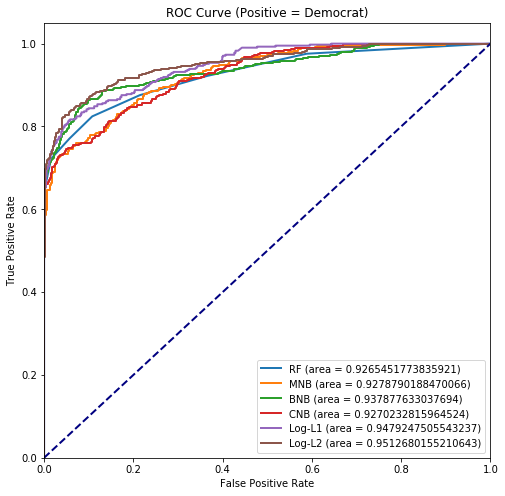

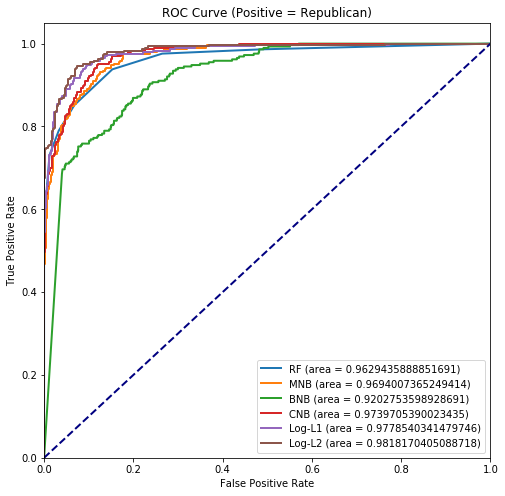

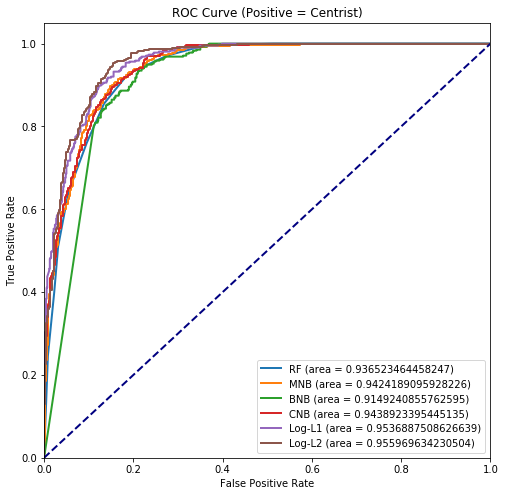

In [26]:
ntnc100_pps = [rf_ntnc_pv, mnb_ntnc_pv, bnb_ntnc_pv, cnb_ntnc_pv, l1_ntnc_pv, l2_ntnc_pv]
names = ['RF', 'MNB', 'BNB', 'CNB', 'Log-L1', 'Log-L2']
graphTitle = 'Filtered Data'
makeROC(ntnc100_pps, y_test_ntnc_pv, names, graphTitle)

In [22]:
with open('vocab_ntnc_100.pickle', 'rb') as dest:
    vocab_ntnc_100 = pickle.load(dest)

In [30]:
# returns support
ll2, ll2_selected = makell2(X_ntnc, y_ntnc)

Logistic accuracy: 0.8500897666068222
Logistic num features: 4156


In [31]:
selected_indices = np.where(ll2_selected == True)[0]

In [32]:
shortened_vocab = []
for i in selected_indices:
    shortened_vocab.append(vocab_ntnc_100[i])

In [36]:
importantWords(0, ll2.estimator_, shortened_vocab)

Most Negative
['longform' 'left' 'hillary' 'center' 'markets' 'personality' 'idiot'
 'leftist' 'president trump' 'politics' 'first' 'angle' 'says' 'women'
 'repeal' 'conservative' 'china' 'california' 'maccallum' 'debate'
 'story maccallum' 'abortion' 'illegals' 'longform angle' 'longform story'
 'maccallum longform' 'asia' 'television' 'conservatives' 'kid' 'jesus'
 'want' 'story' 'syria' 'wife' 'jason' 'leftists' 'season' 'venezuela'
 'agree']
Most Positive
['fake' 'trump' 'cuomo' 'last word' 'celebrities' 'depth analysis'
 'informed perspectives' 'perspectives' 'depth' 'comedy' 'hardball' 'last'
 'readmsnbcsubscribe' 'connect readmsnbcsubscribe' 'informed'
 'readmsnbcsubscribe newslettersyoutubefind' 'newslettersyoutubefind'
 'putin' 'night' 'jokes' 'access' 'breaking us' 'black' 'stone' 'humor'
 'nixon' 'ipad' 'premier' 'progressive' 'bits' 'joke' 'nra' 'connect'
 'manafort' 'lies' 'carter' '000' 'oh' 'jon' 'clips']


In [37]:
importantWords(1, ll2.estimator_, shortened_vocab)

Most Negative
['fake' 'center' 'trump' 'donald' 'sad' 'world' 'girl' 'lady' 'markets'
 'democracy' 'kill' 'connect' '11' 'rich' 'family' 'donald trump' 'tumblr'
 'last word' 'eu' 'ass' 'corporate' 'heart' 'ppl' 'girls' 'days' 'poor'
 'ceo' 'coverage' 'fucked' 'interviews' 'biden' 'pence' 'mom'
 'perspectives' 'depth analysis' 'informed perspectives' 'depth' 'photo'
 'money' 'pussy']
Most Positive
['longform' 'left' 'personality' 'repeal' 'conservative' 'abortion'
 'democrats' 'agree' 'leftist' 'right' 'amendment' 'kingdom' 'maccallum'
 'story maccallum' 'conservatives' 'sunday' 'maccallum longform'
 'longform story' 'longform angle' 'angle' 'album' 'israel' 'jesus' 'five'
 'argument' 'leftists' 'think' 'hillary' 'socialism' 'conversation' 'anti'
 'illegals' 'season' 'baier' 'president trump' 'opinion' 'politics'
 'listen' 'territory' 'point']


In [38]:
importantWords(2, ll2.estimator_, shortened_vocab)

Most Negative
['longform' 'left' 'democrats' 'love' 'amendment' 'aoc' 'album'
 'republicans' 'judge' 'repeal' 'fake' 'cuomo' 'night' 'comedy' 'kingdom'
 'climate' 'liberal' 'pelosi' 'right' 'conservative' 'agree' 'personality'
 'abortion' 'get' 'racist' 'star' 'trump' 'would' 'anyone' 'omar' 'humor'
 'question' 'celebrities' 'last word' 'graham' 'anti' 'joke' 'cortez'
 'think' 'needs']
Most Positive
['center' 'markets' 'photo' 'china' 'asia' 'eu' 'markets balance' 'car'
 'balance power' 'kill' 'due respect' 'election' 'husband' 'girl'
 'political general' '14q81xyvisit' 'venezuela' 'ass' 'balance' 'jason'
 'poor' 'brexit' 'daughter' 'offering' 'india' 'economy' 'partisan'
 'money' 'happy' 'estate' 'home' 'city' 'presidential' 'tagged'
 'states north' 'game' 'fake fake' 'market' 'kevin' 'oil']
